This code creates LaTeX tables replicating the results from the paper "Understanding Ethnolinguistic Differences The Roles of Geography and Trade" Table 1.

First, we replicate the results in Table 1 using Stata and Python to ensure that different programming languages arrive at the same results. We use his provided data for the replication.

This part has 2 output tables `./tables/stata_table1.tex` and `./tables/python_table1.tex`.

We also provide the Python table with normalized variables. This table can be found `./tables/python_table1_norm.tex`.

An additional Julia notebook replicates Table 1, Table 2, Figure 8, Table 3, Figure 9, and Table 4. This notebook can be found in `./progs/Julia/julia_Dickens.ipynb`.

Second, we re-create buffers from the Ethnologue (refer to notebook XXXXX) v16 and v17. In addition, we use an alternative way of measuring CSI at each buffer. To summarize these results, this second part creates a LaTeX table using the specification (5) in Table 1 with different datasets and variables.

Each column represents a pair of data and independent variables of interest.

- `og variable` is the variable used by Dicken in his analysis (CSI sd and CSI average)
- `our variable` is our defined CSI calculated for buffers similar to Dickens reconstructed from scratch.
- `alt variable` is our defined CSI calculated for alternative buffers.

The output of this code is a LaTeX table (just the table) located in `/tables/table1_3_replication.tex`. As we did previously, we also have the same table with normalized variables and it can be found `/tables/table1_3_replication_norm.tex`

This code also produces some heatmaps to understand the correlation between the variables of interest in each of our studied datasets.

The heatmaps could be located in `/graphs/heatmap*`

# Set Up

In [1]:
import ipystata
import numpy as np
import pandas as pd
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys, os, time
pd.set_option('display.width', 140)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

from IPython.display import display, HTML, Image

path = './'
pathtables = '../../tables/'
pathdickens = '../../Dickens-EJ-2021/ueab065_replication_files/'
path_newdata = '../../data/'
pathgraphs = '../../graphs/'

IPyStata is loaded in batch mode.


## Preparing the Datasets

In [5]:
# Load all datasets
dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
dfor_v16 = pd.read_stata(path_newdata + 'Dickens_OrBuf_v16_stats.dta')
dfor_v17 = pd.read_stata(path_newdata + 'Dickens_OrBuf_v17_stats.dta')
dfor_v16_alt = pd.read_stata(path_newdata + 'Dickens_AltBuf_v16_absdif.dta')
dfor_v17_alt = pd.read_stata(path_newdata + 'Dickens_AltBuf_v17_absdif.dta')

# Redefine some variables to be closer to what Dicken's did
for df in [dfor_v16,dfor_v17]:
    df['csi_change_sd_oj'] = (df.post1500AverageCaloriesstd - df.pre1500AverageCaloriesstd)/1000
    df['csi_sd_oj'] = (df.pre1500AverageCaloriesstd)/1000
    df['csi_change_oj'] = (df.post1500AverageCaloriesmean - df.pre1500AverageCaloriesmean)/1000
    df['csi_oj'] = (df.pre1500AverageCaloriesmean)/1000

# Redefine some variables to be closer to what Dicken's did
for df in [dfor_v16_alt,dfor_v17_alt]:
    df['csi_change_alt'] = (df.post1500AverageCaloriesmean - df.pre1500AverageCaloriesmean)/1000
    df['csi_alt'] = (df.pre1500AverageCaloriesmean)/1000

/tmp/ipykernel_3058165/3472773383.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
/tmp/ipykernel_3058165/3472773383.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
/tmp/ipykernel_3058165/3472773383.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

In [6]:
# We want to make sure that we have the same as Dicken, 
# so we will first restrict our sample to those that have information about lingDist
dfor = dfor[dfor.lingDist.isna() == False]

# Merge the data set for v16
dfor16 = dfor.merge(dfor_v16, how = 'left', on = 'identifier')
dfor16 = dfor16.merge(dfor_v16_alt, how = 'left', on = 'identifier')

# Merge the data set for v16
dfor17 = dfor.merge(dfor_v17, how = 'left', on = 'identifier')
dfor17 = dfor17.merge(dfor_v17_alt, how = 'left', on = 'identifier')

In [7]:
# There is an error in the data v17, where we have 3 buffers that repeat
category_counts = dfor17.identifier.value_counts()
single_obs_categories = category_counts[category_counts != 1].index.tolist()
single_obs_categories

['ALN-SRB-SRP-SRB', 'ALN-SRB-MKD-MKD', 'ALN-SRB-SRP-MKD']

In [8]:
# To fix this we are going to drop these buffers
dfor17 = dfor17[~dfor17.identifier.isin(single_obs_categories)]

# We will also further restrict the sample to those that we have data on csi_alt
dfor17 = dfor17[dfor17.csi_alt.isna() == False]

In [9]:
# Now we fixed the problem.
print(sum(dfor16.csi_alt.isna() == False))
print(sum(dfor17.csi.isna() == False))

8426
7582


In [10]:
# To get the same number of observations in the regressions we also need to identify family1 and family2 singletons
category_counts = dfor16.loc[dfor16.lingDist.isna()==False].groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor16.loc[dfor16.lingDist.isna()==False].groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

dfor16 = dfor16[(~dfor16.family1.isin(singletop_fam1)) & (~dfor16.family2.isin(singletop_fam2))]
print(sum(dfor16.csi_alt.isna() == False))
dfor17 = dfor17[(~dfor17.family1.isin(singletop_fam1)) & (~dfor17.family2.isin(singletop_fam2))]
print(sum(dfor17.csi_alt.isna() == False))

8402
7564


In [11]:
# For specification (6) in Table 1 he also drops the singletons when they are in the same country.
dfor_same_country = dfor16[dfor16.samecountry == 1]
print(dfor_same_country.shape)
category_counts = dfor_same_country.groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country.groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country.groupby('ccode1').identifier.count()
singletop_ccode = category_counts[category_counts == 1].index.tolist()

dfor_same_country = dfor_same_country[(~dfor_same_country.family1.isin(singletop_fam1)) & (~dfor_same_country.family2.isin(singletop_fam2)) & (~dfor_same_country.ccode1.isin(singletop_ccode))]
print(sum(dfor_same_country.csi_alt.isna() == False))

(7312, 409)
7291


In [ ]:
# Here is the code to export the final data used for the analysis

# Get the variables used in the analysis and order them with the csi variables 1st
var_to_keep = dfor.columns.tolist()
var_to_keep.remove("csi")
var_to_keep.remove("csi_sd")
var_to_keep.remove("csi_change")
var_to_keep.remove("csi_change_sd")

var_to_keep = ['csi','csi_sd','csi_change','csi_change_sd','csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj','csi_alt','csi_change_alt'] + var_to_keep

# Export both datasets to .dta format
dfor16[var_to_keep].to_stata(path_newdata + 'Dickens_rep_v16.dta', version=117)
dfor17[var_to_keep].to_stata(path_newdata + 'Dickens_rep_v17.dta', version=117)

Now we want to understand how our new variables compare with the variables created by Dickens. For this we create a heatmap that represents the corr matrix

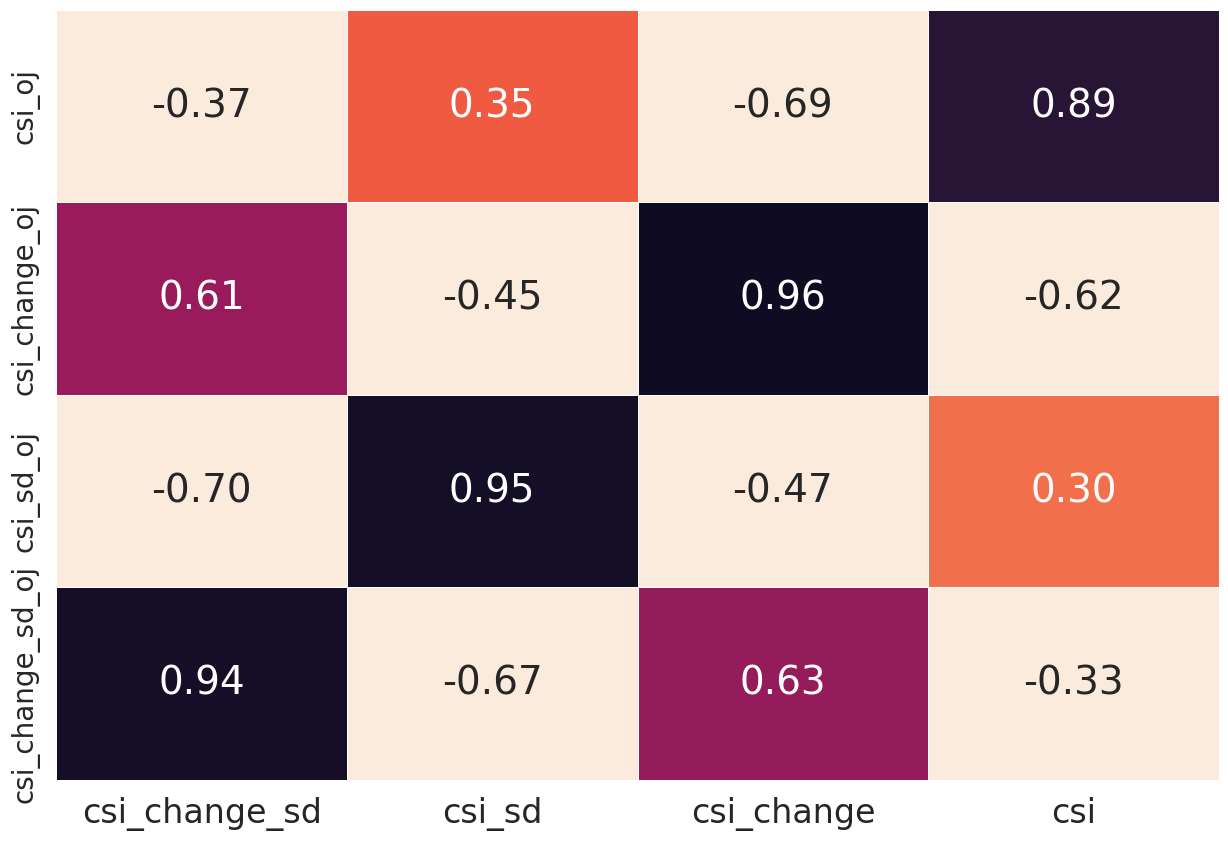

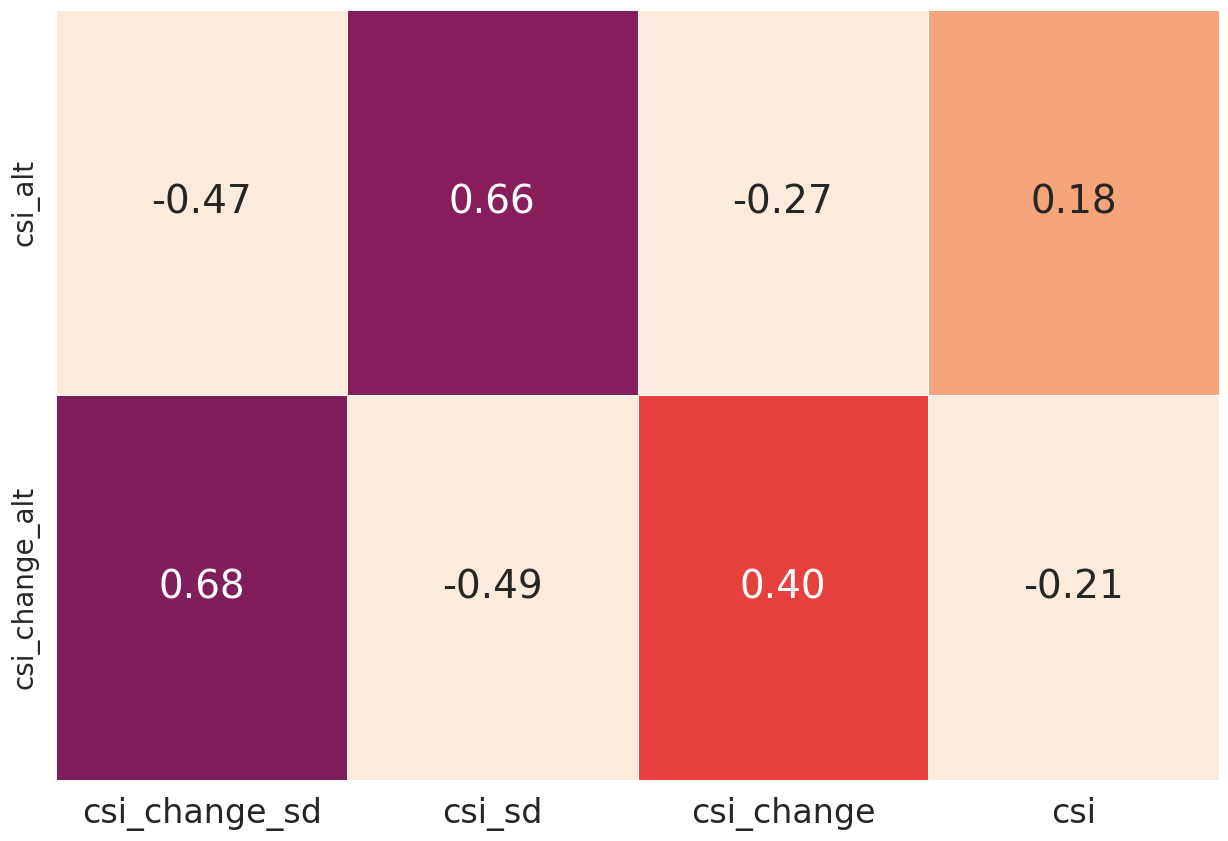

In [12]:
# Create heatmaps to see the correlation between our data (alternative and reconstructed buffers) with Dicken's variables
var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']
myheatmap(dfor16, var1, var2,'v16', show = True)

var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']
myheatmap(dfor17,var1,var2,'v17')

var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_alt','csi_change_alt']
myheatmap(dfor16, var1, var2,'v16_alt', show = True)

var2 = ['csi_change_sd','csi_sd','csi_change','csi']
var1 = ['csi_alt','csi_change_alt']
myheatmap(dfor17,var1,var2,'v17_alt')

# Replication of Table 1 with Stata and Python

## Stata

Here we use the same code Dickens provided in his replication package to check that we can arrive at the results of Table 1 with his data and programming language of choice.

In [13]:
%%stata -d dfor -np --noprint

global prod csi csi_change
global geog malaria elev elev_sd prec prec_sd temp temp_sd
global spatial ldist_lang ldist_coast ldist_border ldist_lake ldist_rivmaj ldist_rivmin ln_langPop ln_langArea langLat_diff langLon_diff
global controls $prod $geog $spatial

eststo clear
eststo r1: qui reghdfe lingDist csi_sd csi_change_sd, ab(family1 family2) cl(langID1 langID2)
quietly estadd local geo_l "No", replace
quietly estadd local sptail_l "No", replace
quietly estadd local langFE "Yes", replace
quietly estadd local contryFE "No", replace
eststo r2: qui reghdfe lingDist csi_sd csi_change_sd $prod, ab(family1 family2) cl(langID1 langID2)
quietly estadd local geo_l "No"
quietly estadd local sptail_l "No"
quietly estadd local langFE "Yes"
quietly estadd local contryFE "No"
eststo r3: qui reghdfe lingDist csi_sd csi_change_sd $prod $geog, ab(family1 family2) cl(langID1 langID2)
quietly estadd local geo_l "Yes"
quietly estadd local sptail_l "No"
quietly estadd local langFE "Yes"
quietly estadd local contryFE "No"
eststo r4: qui reghdfe lingDist csi_sd csi_change_sd $prod $spatial, ab(family1 family2) cl(langID1 langID2)
quietly estadd local geo_l "No"
quietly estadd local sptail_l "Yes"
quietly estadd local langFE "Yes"
quietly estadd local contryFE "No"
eststo r5: qui reghdfe lingDist csi_sd csi_change_sd $controls, ab(family1 family2) cl(langID1 langID2)
quietly estadd local geo_l "Yes"
quietly estadd local sptail_l "Yes"
quietly estadd local langFE "Yes"
quietly estadd local contryFE "No"
eststo r6: qui reghdfe lingDist csi_sd csi_change_sd $controls if samecountry == 1, ab(family1 family2 ccode1) cl(langID1 langID2)
quietly estadd local geo_l "Yes"
quietly estadd local sptail_l "Yes"
quietly estadd local langFE "Yes"
quietly estadd local contryFE "Yes"
esttab r1 r2 r3 r4 r5 r6 using "../../tables/stata_table1.tex", replace  label     ///
    keep(*csi_change_sd *csi_sd *csi_change *csi) 			                ///
	order(*csi_change_sd *csi_sd *csi_change *csi) 				            ///
    cells(b(fmt(%9.3f)) se(par fmt(%9.3f)) p(par("[" "]") fmt(%9.3f)))      ///
	varlabels(csi "Land productivity (pre-1500)" 				            ///
	csi_change "$\Delta$ in land prod (post-1500)" 				            ///
	csi_sd "Land prod variation (pre-1500)" 					            ///
	csi_change_sd "$\Delta$ in land prod var (post-1500)")                    ///
    stats(geo_l sptail_l langFE contryFE r2_a N,                   ///
	label("Geography controls" "Spatial controls" "Language family FE" "Country FEs" "Adjusted R2" "Observations") ///
    fmt(%9.3f %9.3f %9.3f %9.3f %9.3f 30)) 


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: 4-user 8-core network perpetual
Serial number: 501706314448
  Licensed to: Southern Methodist University
               Dallas, Texas

Notes:
      1. Stata is running in batch mode.
      2. Unicode is supported; see help unicode_advice.
      3. More than 2 billion observations are allowed; see help obs_advice.
      4. Maximum number of variables is set to 5,000; see help set_maxvar.

. do /users/gonzalezjj/.cache/ipython/stata/code.do 

. clear

. set more off

.

In [14]:
# We need to modify Stata's .tex table to make it look like Table 1 in the paper.
modify_stata_latex_output("stata_table1")

## Python

Note that Python doesn't have a package that implements the `reghdfe` procedures.

For this replication we found that using a dummies for the two Language Families provides the closest replication of the results.

In [15]:
# Set up 

# Define the variables of interest
var_of_interest = ['lingDist','csi_change_sd', 'csi_sd']

# Set up some controls
prod = ['csi_change', 'csi']
geog = ['malaria', 'elev', 'elev_sd', 'prec', 'prec_sd', 'temp', 'temp_sd']
spatial = ['ldist_lang', 'ldist_coast', 'ldist_border', 'ldist_lake', 'ldist_rivmaj', 
           'ldist_rivmin', 'ln_langPop', 'ln_langArea', 'langLat_diff', 'langLon_diff']

# Include the main covariates in the right side (variations and levels)
x_vars = ['csi_change_sd', 'csi_sd'] + prod

In [16]:
# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

In [17]:
# Output the results of the previous regression.
latex_table_1_rep("python_table1")

### Normalized

In [18]:
# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

In [19]:
# Output the results of the previous regression.
latex_table_1_rep("python_table1_norm")

# Replication of Table 1 Specification (5) with alternative data

In [20]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Columna 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Columna 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Columna 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Columna 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Columna 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

# Columna 8 : our data alternative buffer, our sample v16, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est8_b = est1.params[x_vars2]
est8_se = est1.bse[x_vars2]
est8_p = est1.pvalues[x_vars2]
ad_R8 = est1.rsquared_adj
N8 = est1.nobs

# Columna 9 : our data alternative buffer, our sample v17, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est9_b = est1.params[x_vars2]
est9_se = est1.bse[x_vars2]
est9_p = est1.pvalues[x_vars2]
ad_R9 = est1.rsquared_adj
N9 = est1.nobs

In [21]:
# Output the results of the previous regression.
latex_table_diffsamples("table1_3_replication")

## Normalized

In [22]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Columna 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Columna 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Columna 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Columna 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Columna 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

# Columna 8 : our data alternative buffer, our sample v16, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est8_b = est1.params[x_vars2]
est8_se = est1.bse[x_vars2]
est8_p = est1.pvalues[x_vars2]
ad_R8 = est1.rsquared_adj
N8 = est1.nobs

# Columna 9 : our data alternative buffer, our sample v17, horse race
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi','csi_change_alt','csi_alt']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est9_b = est1.params[x_vars2]
est9_se = est1.bse[x_vars2]
est9_p = est1.pvalues[x_vars2]
ad_R9 = est1.rsquared_adj
N9 = est1.nobs

In [23]:
latex_table_diffsamples("table1_3_replication_norm")